In [137]:
%load_ext autoreload
%autoreload
%matplotlib widget
from N_xi_fit_funcs import *
import phaseco as pc
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import correlate, get_window, convolve, correlation_lags
from scipy.optimize import curve_fit
import os


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [93]:
# Directories
os.chdir(r"C:\Users\setht\Dropbox\Citadel\GitHub\phase-coherence")
pkl_folder = r"C:\Users\setht\Dropbox\Citadel\GitHub\phase-coherence\paper_analysis\pickles"

In [111]:
# Get waveform
wf_idx = 2
species = "Owl"
wf_len_s = 1
wf, wf_fn, fs, good_peak_freqs, bad_peak_freqs = get_wf(
    species=species,
    wf_idx=wf_idx,
)

f0 = good_peak_freqs[1]

In [131]:
xis = get_xis_array((0.001, 0.1, 0.001), fs, hop=round(fs*0.001))
print(xis)

delta_xi=xi_min=hop=44, so each xi is an integer num of segs, so we just need a single stft per xi! NICE!
[  44   88  132  176  220  264  308  352  396  440  484  528  572  616
  660  704  748  792  836  880  924  968 1012 1056 1100 1144 1188 1232
 1276 1320 1364 1408 1452 1496 1540 1584 1628 1672 1716 1760 1804 1848
 1892 1936 1980 2024 2068 2112 2156 2200 2244 2288 2332 2376 2420 2464
 2508 2552 2596 2640 2684 2728 2772 2816 2860 2904 2948 2992 3036 3080
 3124 3168 3212 3256 3300 3344 3388 3432 3476 3520 3564 3608 3652 3696
 3740 3784 3828 3872 3916 3960 4004 4048 4092 4136 4180 4224 4268 4312
 4356 4400]


In [132]:
# Get colossogram
win_type = "flattop"
win_meth = {"method": "static", "win_type": win_type}
bw = 200
pw = True
demean = True
tau = get_precalc_tau_from_bw(bw, fs, win_type, pkl_folder)
nfft = tau
hop = 1
xis = {"xi_min_s": 0.001, "xi_max_s": 0.1, "delta_xi_s": 0.001}
f0s = [f0]
cgram_dict = load_calc_colossogram(
    **{
        "wf": wf,
        "wf_idx": wf_idx,
        "wf_fn": wf_fn,
        "wf_len_s": wf_len_s,
        "wf_pp": None,
        "species": species,
        "fs": fs,
        "filter_meth": None,
        "pkl_folder": pkl_folder,
        "pw": pw,
        "tau": tau,
        "nfft": nfft,
        "xi_min_s": xis["xi_min_s"],
        "xi_max_s": xis["xi_max_s"],
        "hop": hop,
        "win_meth": win_meth,
        "force_recalc_colossogram": 0,
        "plot_what_we_got": 0,
        "only_calc_new_coherences": 0,
        "const_N_pd": 0, # Equivalent to mode='valid' in scipy convolve. If True, then no correspondence in scipy.
        "scale": True,
        "N_bs": 0,
        "f0s": f0s,
        "demean": demean,
    }
)
f = cgram_dict["f"]
f0_exact = f[np.argmin(np.abs(f - f0))]

# Process waveform
wf = crop_wf(wf, fs, wf_len_s)
wf = scale_wf(wf, species)
if demean:
    wf -= np.mean(wf)

Processing 'C:\Users\setht\Dropbox\Citadel\GitHub\phase-coherence\paper_analysis\pickles\Owl 2, PW=True, Static Flattop, hop=1, tau=821, filter=None, xi_max=100ms, nfft=821, f0s=[8096], N_pd=max, DM=True, wf_len=1s, wf=TAG6rearSOAEwf1 (Colossogram).pkl'


In [133]:
"Plot colosogram"
# pc.plot_colossogram(cgram_dict['xis_s'], cgram_dict['f'], cgram_dict['colossogram'])
# plt.xlim(None, 20)
# plt.ylim(3, 12)

'Plot colosogram'

In [134]:
"Get single narrowband around f0"
win = get_window(win_type, tau)
omega_0_norm = f0_exact * 2*np.pi / fs
n = np.arange(len(win))
kernel = win * np.exp(1j * omega_0_norm * n)
wf_filtered = convolve(wf, kernel, mode='valid', method='fft')

# Normalize amplitude
if not pw:
    wf_filtered = wf_filtered / np.abs(wf_filtered)
acf = correlate(wf_filtered, wf_filtered, mode='full', method='auto')
N = len(wf_filtered)
lags = correlation_lags(N, N, mode='full')
# Crop since don't need the larger lags
acf = acf[30000:-30000]
lags = lags[30000:-30000]

# Get some lag-related vars
lags_ms = lags / fs * 1000
zero_lag_idx = len(lags)//2 # index of zero lag
lags_abs = np.abs(lags)
num_terms = N - lags_abs # number of terms in each ACF calculation

# Normalize if pw
if pw:
    # Construct variance array for exact correspondence with PW C_xi calculation
    var_xi = np.empty(len(lags))
    for k, lag_abs in enumerate(tqdm(lags_abs)):
        if lag_abs == 0:
            var_xi[k] = np.var(wf_filtered)
        else:
            var_xi[k] = np.sqrt(np.var(wf_filtered[lag_abs:])*np.var(wf_filtered[:-lag_abs]))
    # var_xi = np.var(wf_filtered)

    acf_norm = np.abs(acf)/(num_terms*var_xi) 
    
# Otherwise we just have to divide by the number of terms
else:
    acf_norm = np.abs(acf)/num_terms

100%|██████████| 26559/26559 [00:04<00:00, 5617.55it/s]


c:\Users\setht\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\setht\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:212: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


[FITTING 8111Hz AUTOCOHERENCE DECAY]
One peak found in first 26ms of xi, starting fit here
Fitting...
Fit succeeded on first try!


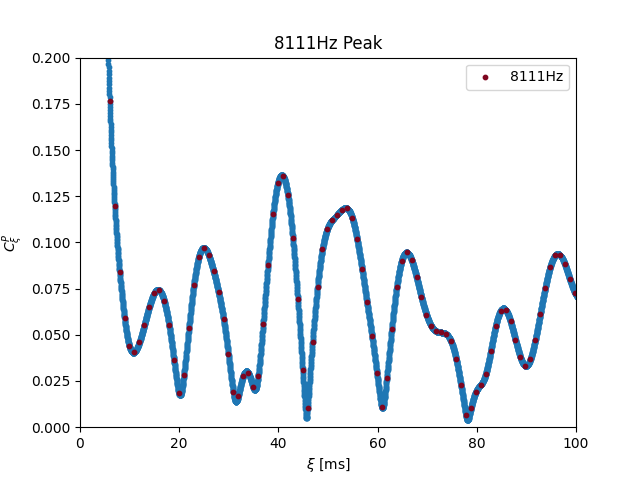

In [135]:
plt.close('all')
plt.figure()
plt.scatter(lags_ms[zero_lag_idx:], acf_norm[zero_lag_idx:], s=10)
N_xi, N_xi_dict = pc.get_N_xi(cgram_dict, f0)
pc.plot_N_xi_fit(N_xi_dict, plot_noise_floor=False, plot_fit=False)
plt.xlim(0, 100)
plt.ylim(0, 0.2)
plt.show()

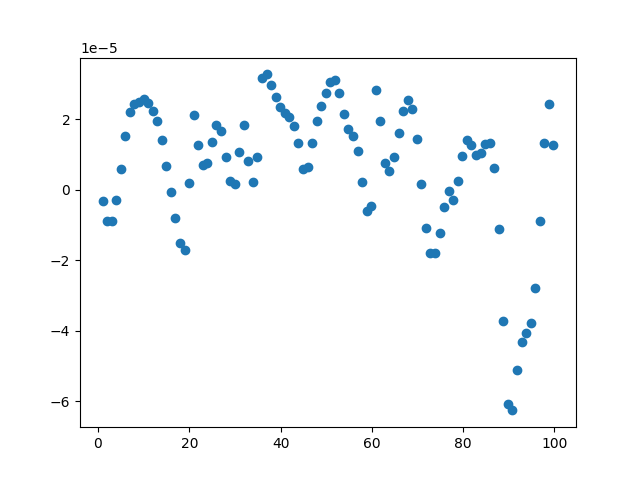

In [136]:
plt.close('all')
plt.figure()
cgram_slice = N_xi_dict['colossogram_slice']
xis_ms = N_xi_dict['xis_s'] * 1000
# pos_lags_ms, pos_acf_norm = lags_ms[zero_lag_idx:zero_lag_idx + len(xis_ms)], acf_norm[zero_lag_idx:zero_lag_idx + len(xis_ms)]
selected_lag_idxs = np.argmin(np.abs(xis_ms[:, None] - lags_ms[None, :]), axis=1)
diff = acf_norm[selected_lag_idxs] - cgram_slice
plt.scatter(xis_ms, diff)
plt.show()

# Small discrepancy is likely because we divide by the variance estimate Pxx which varies with xi (different number of segs) rather than the explicit variance of the whole waveform